# Identifying Friendly Squirrels #

In [1]:
from __future__ import print_function
from packaging.version import parse as Version
from platform import python_version

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.12 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == Version(min_ver):
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(python_version())

if pyversion >= Version("3.12.5"):
    print(OK, "Python version is %s" % pyversion)
elif pyversion < Version("3.12.5"):
    print(FAIL, "Python version 3.12.5 is required,"
                " but %s is installed." % pyversion)
else:
    print(FAIL, "Unknown Python version: %s" % pyversion)

    
print()
requirements = {'numpy': "1.26.4", 'matplotlib': "3.9.2",'sklearn': "1.5.1", 
                'pandas': "2.2.2",'xgboost': "2.1.1", 'shap': "0.45.1", 
                'plotly': "5.23.0"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.12.5

[ OK ] numpy version 1.26.4 is installed.
[ OK ] matplotlib version 3.9.2 is installed.
[ OK ] sklearn version 1.5.1 is installed.
[ OK ] pandas version 2.2.2 is installed.
[ OK ] xgboost version 2.1.1 is installed.
[ OK ] shap version 0.45.1 is installed.
[ OK ] plotly version 5.23.0 is installed.


In [2]:
import numpy as np 
import pandas as pd
import matplotlib 
from matplotlib import pylab as plt
import os
import warnings
warnings.filterwarnings('ignore') #ignore warning messages 

In [3]:
# Load dataset
df_original = pd.read_csv('/Users/songxiaoke/Desktop/1030project_squirrels/data/central_part_squirrels_(raw).csv')
df_original.head()

,X,Y,Unique Squirrel ID,Hectare,Shift,Date,Hectare Squirrel Number,Age,Primary Fur Color,Highlight Fur Color,...,Kuks,Quaas,Moans,Tail flags,Tail twitches,Approaches,Indifferent,Runs from,Other Interactions,Lat/Long
0,-73.956134,40.794082,37F-PM-1014-03,37F,PM,10142018,3,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,NaN,POINT (-73.9561344937861 40.7940823884086)
1,-73.968857,40.783783,21B-AM-1019-04,21B,AM,10192018,4,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,NaN,POINT (-73.9688574691102 40.7837825208444)
2,-73.974281,40.775534,11B-PM-1014-08,11B,PM,10142018,8,NaN,Gray,NaN,...,False,False,False,False,False,False,False,False,NaN,POINT (-73.97428114848522 40.775533619083)
3,-73.959641,40.790313,32E-PM-1017-14,32E,PM,10172018,14,Adult,Gray,NaN,...,False,False,False,False,False,False,False,True,NaN,POINT (-73.9596413903948 40.7903128889029)
4,-73.970268,40.776213,13E-AM-1017-05,13E,AM,10172018,5,Adult,Gray,Cinnamon,...,False,False,False,False,False,False,False,False,NaN,POINT (-73.9702676472613 40.7762126854894)


# Exploratory Data Analysis #

In [4]:
print(df_original.shape)

(3023, 31)


In [5]:
df_original.describe()

,X,Y,Date,Hectare Squirrel Number
count,3023.000000,3023.000000,3.023000e+03,3023.000000
mean,-73.967184,40.780853,1.011949e+07,4.123718
std,0.007726,0.010285,4.246671e+04,3.096492
min,-73.981159,40.764911,1.006202e+07,1.000000
25%,-73.973102,40.771676,1.008202e+07,2.000000
50%,-73.968594,40.778166,1.012202e+07,3.000000
75%,-73.960189,40.791219,1.014202e+07,6.000000
max,-73.949722,40.800119,1.020202e+07,23.000000


#### Check Missing Values for Original Datasets ####

In [6]:
# Check Missing valyes for Original Datasets
perc_missing_per_ftr = df_original.isnull().sum(axis = 0)/df_original.shape[0]
print('fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])
print('data types of the features with missing values:')
print(df_original[perc_missing_per_ftr[perc_missing_per_ftr > 0].index].dtypes)
frac_missing = sum(df_original.isnull().sum(axis = 1)!=0)/df_original.shape[0]
print('fraction of points with missing vlaues:', frac_missing)

fraction of missing values in features:
Age                                 0.040026
Primary Fur Color                   0.018194
Highlight Fur Color                 0.359246
Color notes                         0.939795
Location                            0.021171
Above Ground Sighter Measurement    0.037711
Specific Location                   0.842541
Other Activities                    0.855442
Other Interactions                  0.920609
dtype: float64
data types of the features with missing values:
Age                                 object
Primary Fur Color                   object
Highlight Fur Color                 object
Color notes                         object
Location                            object
Above Ground Sighter Measurement    object
Specific Location                   object
Other Activities                    object
Other Interactions                  object
dtype: object
fraction of points with missing vlaues: 0.9996692027786966


#### Drop Feratures Provide No Predictive Power ####

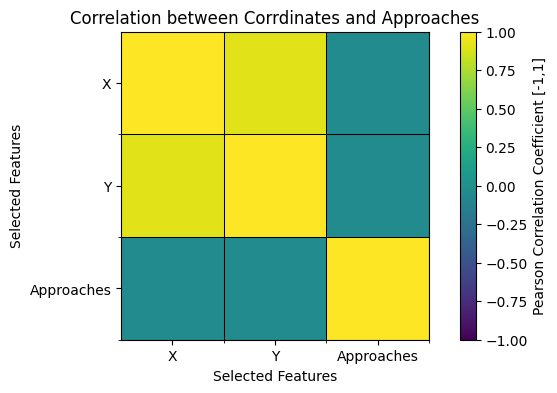

In [7]:
# Test Correlation Between Approaches and X, Y

selected = ['X', 'Y', 'Approaches']

corr_matrix = df_original[selected].corr()

plt.figure(figsize = (8,4))
plt.imshow(corr_matrix, vmin = -1, vmax = 1)
plt.colorbar(label = 'Pearson Correlation Coefficient [-1,1]')

ax = plt.gca()
ax.set_xticks(np.arange(len(corr_matrix.columns)) + 0.5, minor=True)
ax.set_yticks(np.arange(len(corr_matrix.columns)) + 0.5, minor=True)
ax.grid(which='minor', color='black', linestyle='-', linewidth=0.75)

plt.title('Correlation between Corrdinates and Approaches')
plt.xlabel('Selected Features')
plt.ylabel('Selected Features')
plt.xticks(np.arange(len(corr_matrix.columns)), corr_matrix.columns)
plt.yticks(np.arange(len(corr_matrix.columns)), corr_matrix.columns)

# Save the plot to the specified path
# desktop_path = os.path.join(os.path.expanduser("~"), "Desktop", "correlation_plot.png")
# plt.savefig(fname=desktop_path, format='png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
# Drop columns provide no predictive values
columns_to_drop = ['X', 'Y', 'Unique Squirrel ID', 'Hectare', 'Date', 
                   'Hectare Squirrel Number',  
                   'Combination of Primary and Highlight Color', 'Specific Location',
                   'Color notes', 'Lat/Long', 'Above Ground Sighter Measurement',
                  'Other Interactions','Other Activities']
df = df_original.drop(columns=columns_to_drop)
print(df.shape)
df.head()

(3023, 18)


,Shift,Age,Primary Fur Color,Highlight Fur Color,Location,Running,Chasing,Climbing,Eating,Foraging,Kuks,Quaas,Moans,Tail flags,Tail twitches,Approaches,Indifferent,Runs from
0,PM,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False
1,AM,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False
2,PM,NaN,Gray,NaN,Above Ground,False,True,False,False,False,False,False,False,False,False,False,False,False
3,PM,Adult,Gray,NaN,NaN,False,False,False,True,True,False,False,False,False,False,False,False,True
4,AM,Adult,Gray,Cinnamon,Above Ground,False,False,False,False,True,False,False,False,False,False,False,False,False


In [9]:
df.describe()

,Shift,Age,Primary Fur Color,Highlight Fur Color,Location,Running,Chasing,Climbing,Eating,Foraging,Kuks,Quaas,Moans,Tail flags,Tail twitches,Approaches,Indifferent,Runs from
count,3023,2902,2968,1937,2959,3023,3023,3023,3023,3023,3023,3023,3023,3023,3023,3023,3023,3023
unique,2,3,3,10,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,PM,Adult,Gray,Cinnamon,Ground Plane,False,False,False,False,False,False,False,False,False,False,False,False,False
freq,1676,2568,2473,767,2116,2293,2744,2365,2263,1588,2921,2973,3020,2868,2589,2845,1569,2345


In [10]:
# Identify data types for each columns
print(df.dtypes)

Shift                  object
Age                    object
Primary Fur Color      object
Highlight Fur Color    object
Location               object
Running                  bool
Chasing                  bool
Climbing                 bool
Eating                   bool
Foraging                 bool
Kuks                     bool
Quaas                    bool
Moans                    bool
Tail flags               bool
Tail twitches            bool
Approaches               bool
Indifferent              bool
Runs from                bool
dtype: object


#### Re-Check Missing Values after Dropping Features with No Predictive Power ####

In [11]:
# Check Missing value
print('number of corresponding missing values:')
print(df.isnull().sum())

number of corresponding missing values:
Shift                     0
Age                     121
Primary Fur Color        55
Highlight Fur Color    1086
Location                 64
Running                   0
Chasing                   0
Climbing                  0
Eating                    0
Foraging                  0
Kuks                      0
Quaas                     0
Moans                     0
Tail flags                0
Tail twitches             0
Approaches                0
Indifferent               0
Runs from                 0
dtype: int64


In [12]:
# Check Missing valyes for Original Datasets
perc_missing_per_ftr = df.isnull().sum(axis = 0)/df.shape[0]
print('fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])
print('data types of the features with missing values:')
print(df[perc_missing_per_ftr[perc_missing_per_ftr > 0].index].dtypes)
frac_missing = sum(df.isnull().sum(axis = 1)!=0)/df.shape[0]
print('fraction of points with missing vlaues:', frac_missing)

fraction of missing values in features:
Age                    0.040026
Primary Fur Color      0.018194
Highlight Fur Color    0.359246
Location               0.021171
dtype: float64
data types of the features with missing values:
Age                    object
Primary Fur Color      object
Highlight Fur Color    object
Location               object
dtype: object
fraction of points with missing vlaues: 0.38901753225272906


#### Replace nan with 'Unknown' for Categorical features ####

In [13]:
df['Age'] = df['Age'].replace('?', np.nan)
df['Age'] = df['Age'].fillna('Unknown') 
print(df['Age'].unique())

['Unknown' 'Adult' 'Juvenile']


In [14]:
df['Primary Fur Color'] = df['Primary Fur Color'].fillna('Unknown') 
print(df['Primary Fur Color'].unique())

['Unknown' 'Gray' 'Cinnamon' 'Black']


In [15]:
df['Location'] = df['Location'].fillna('Unknown') 
print(df['Location'].unique())

['Unknown' 'Above Ground' 'Ground Plane']


In [16]:
df['Highlight Fur Color'] = df['Highlight Fur Color'].fillna('Unknown') 
print(df['Highlight Fur Color'].unique())

['Unknown' 'Cinnamon' 'White' 'Gray' 'Cinnamon, White' 'Gray, White'
 'Black, Cinnamon, White' 'Black' 'Black, White' 'Black, Cinnamon'
 'Gray, Black']


#### Balances of each class in the Target variable & Visualization ####

[False  True]
Approaches
False    2845
True      178
Name: count, dtype: int64


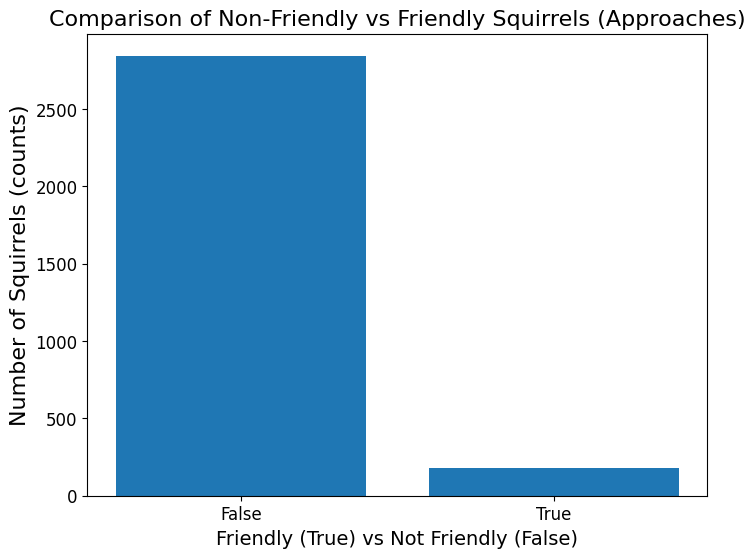

In [17]:
# Check distribution of target variable 'Approaches'
print(df['Approaches'].unique())
print(df['Approaches'].value_counts())

# A bar plot to show distribution
plt.figure(figsize = (8,6))
plt.bar(df['Approaches'].value_counts().index.astype(str), height = df_original['Approaches'].value_counts().values)
plt.title('Comparison of Non-Friendly vs Friendly Squirrels (Approaches)', fontsize=16)
plt.xlabel('Friendly (True) vs Not Friendly (False)', fontsize=14)
plt.ylabel('Number of Squirrels (counts)', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# desktop_path = os.path.join(os.path.expanduser("~"), "Desktop", "squirrel_approaches_distribution.png")
# plt.savefig(fname=desktop_path, format='png', dpi=300, bbox_inches='tight')
plt.show()

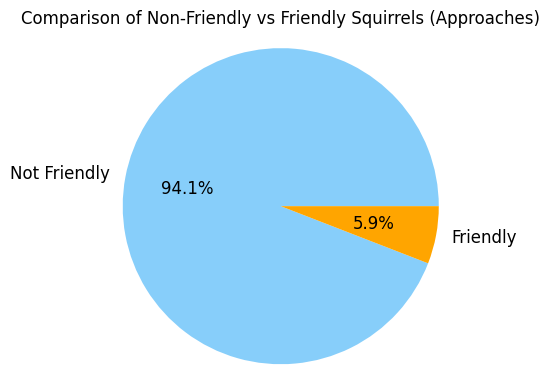

In [18]:
# Similar but Pie Plot
plt.figure(figsize=(5, 4))
plt.pie(df_original['Approaches'].value_counts(), labels=['Not Friendly', 'Friendly'], 
        autopct='%1.1f%%', textprops={'fontsize': 12}, colors = ['lightskyblue', 'orange'])
plt.title('Comparison of Non-Friendly vs Friendly Squirrels (Approaches)', fontsize=12)
plt.axis('equal')
plt.tight_layout()

# desktop_path = os.path.join(os.path.expanduser("~"), "Desktop", "squirrel_distribution_pie.png")
# plt.savefig(fname=desktop_path, format='png', dpi=300, bbox_inches='tight')
plt.show()

#### Squirrels Distribution thoughout the Park ####

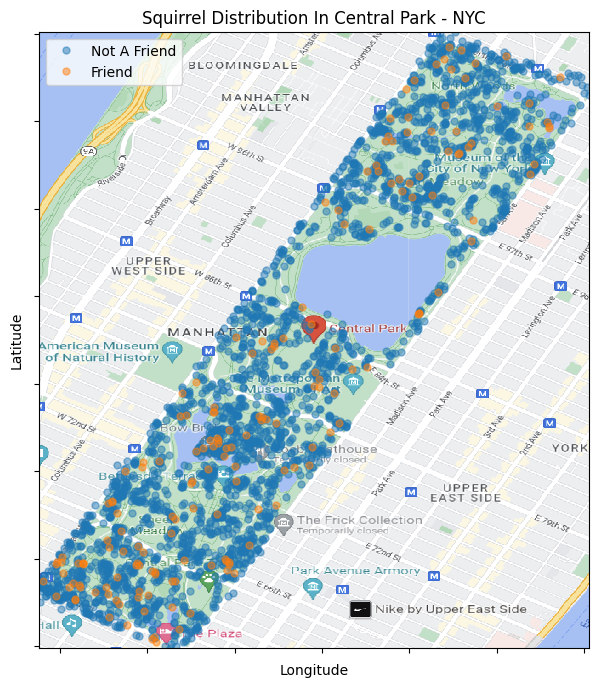

In [19]:
image_path = os.path.join(os.path.expanduser("~"), "Desktop", "1030project_squirrels", "figures", "central_park.png")

extent = (df_original['X'].min(), df_original['X'].max(), df_original['Y'].min(), df_original['Y'].max())
im = plt.imread(image_path)

plt.figure(figsize=(10, 8))
plt.imshow(im, interpolation='nearest', extent=extent)

sq_groups = df_original.groupby('Approaches')

for name, group in sq_groups:
    label = 'Friend' if name else 'Not A Friend'
    plt.plot(group['X'], group['Y'], marker='o', linestyle='', markersize=5, label=label, alpha=0.5)

plt.title('Squirrel Distribution In Central Park - NYC')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(loc='upper left')
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])

# save_path = os.path.join(os.path.expanduser("~"), "Desktop", "squirrel_distribution_cp.png")
# plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')
plt.show()

#### More Visualizations Investigating different Features ####

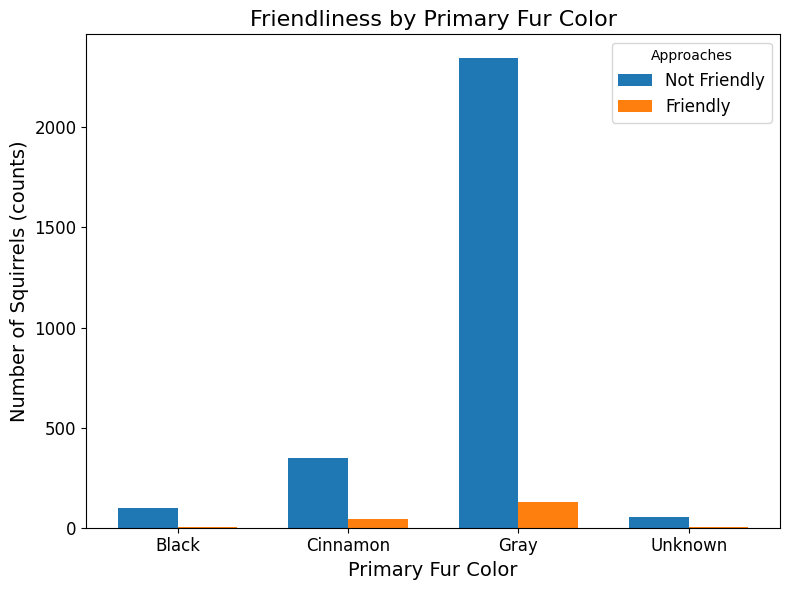

In [20]:
# Whether squirrels of different fur colors are more or less likely to approach humans
fur_counts = df.groupby('Primary Fur Color')['Approaches'].value_counts().unstack(fill_value=0)

# Create a bar plot
bar_width = 0.35
index = np.arange(len(fur_counts))
plt.figure(figsize=(8, 6))
plt.bar(index, fur_counts[False], bar_width, label='Not Friendly')
plt.bar(index + bar_width, fur_counts[True], bar_width, label='Friendly')
plt.title('Friendliness by Primary Fur Color', fontsize=16) 
plt.xlabel('Primary Fur Color', fontsize=14)  
plt.ylabel('Number of Squirrels (counts)', fontsize=14)  
plt.xticks(index + bar_width / 2, fur_counts.index, fontsize=12)
plt.yticks(fontsize=12) 
plt.legend(['Not Friendly', 'Friendly'], title="Approaches", fontsize=12)
plt.tight_layout()

# save_path = os.path.join(os.path.expanduser("~"), "Desktop", "Comparison_furcolor.png")
# plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')
plt.show()

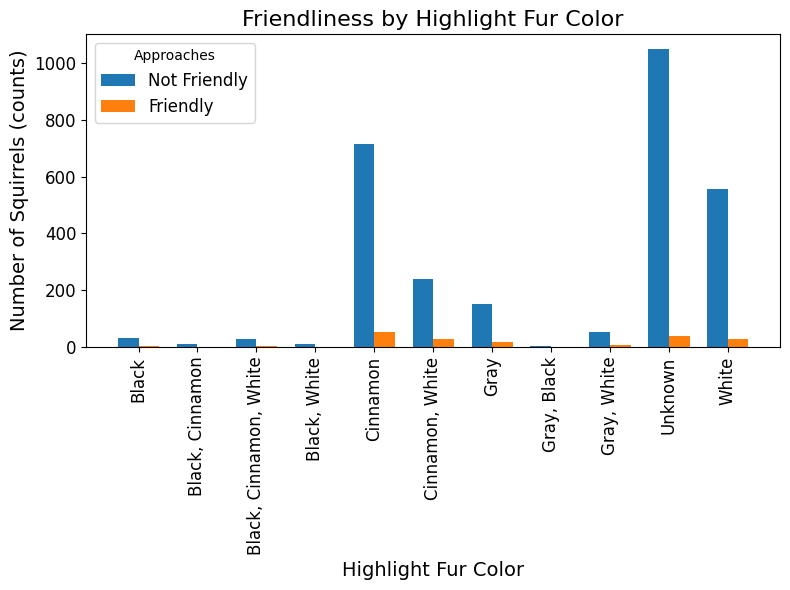

In [21]:
# Highlight Fur Color
fur_high_counts = df.groupby('Highlight Fur Color')['Approaches'].value_counts().unstack(fill_value=0)

# Create a bar plot
bar_width = 0.35
index = np.arange(len(fur_high_counts))
plt.figure(figsize=(8, 6))
plt.bar(index, fur_high_counts[False], bar_width, label='Not Friendly')
plt.bar(index + bar_width, fur_high_counts[True], bar_width, label='Friendly')
plt.title('Friendliness by Highlight Fur Color', fontsize=16) 
plt.xlabel('Highlight Fur Color', fontsize=14)  
plt.ylabel('Number of Squirrels (counts)', fontsize=14)  
plt.xticks(index + bar_width / 2, fur_high_counts.index, fontsize=12, rotation = 90)
plt.yticks(fontsize=12) 
plt.legend(['Not Friendly', 'Friendly'], title="Approaches", fontsize=12)
plt.tight_layout()

# save_path = os.path.join(os.path.expanduser("~"), "Desktop", "Comparison_highlight_furcolor.png")
# plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')
plt.show()

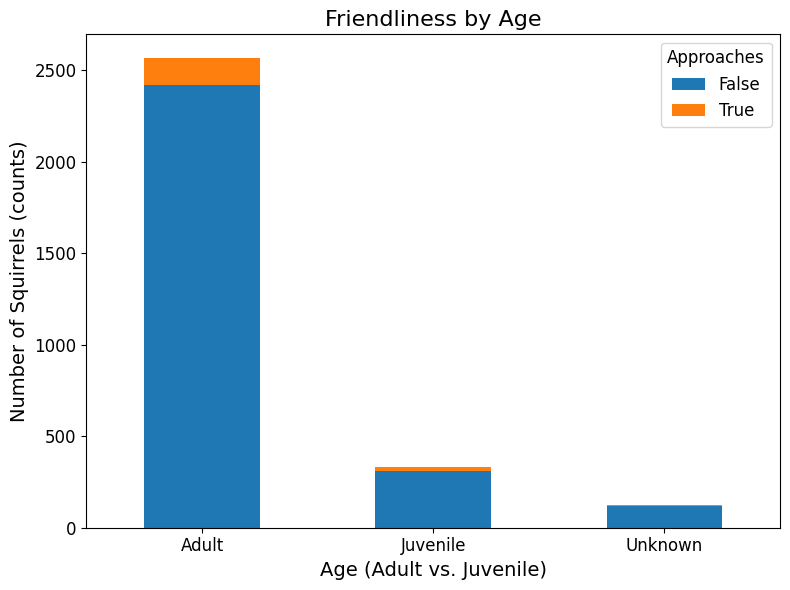

In [22]:
# Visulaize if age (adult vs. juvenile) affects how friendly squirrels are
age_counts = df.groupby('Age')['Approaches'].value_counts().unstack().dropna()

# Stacked bar plot
age_counts.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.title('Friendliness by Age', fontsize=16)  
plt.xlabel('Age (Adult vs. Juvenile)', fontsize=14)  
plt.ylabel('Number of Squirrels (counts)', fontsize=14)
plt.xticks(rotation=0, fontsize=12) 
plt.yticks(fontsize=12)
plt.legend(title="Approaches", fontsize=12, title_fontsize=12)
plt.tight_layout()

# save_path = os.path.join(os.path.expanduser("~"), "Desktop", "Comparison_age.png")
# plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')
plt.show()

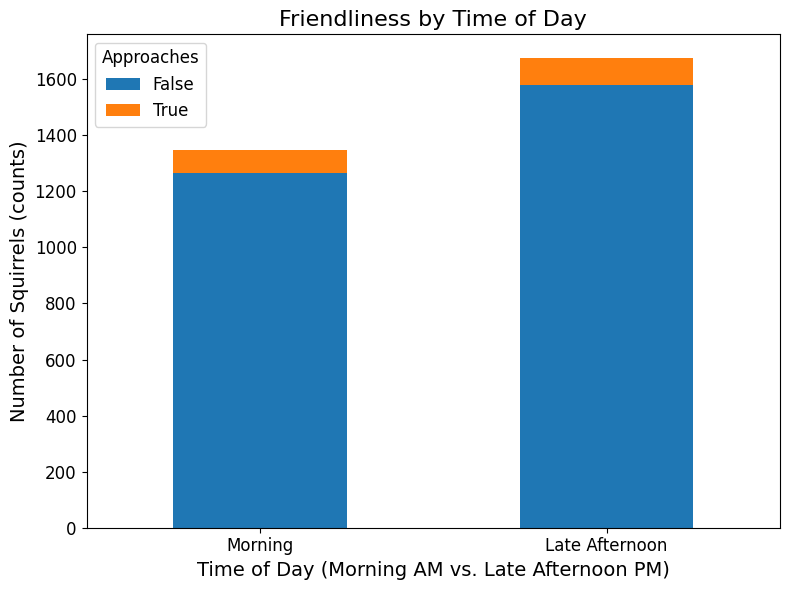

In [23]:
# if the time of day (shift: morning vs. late afternoon) influences squirrel behavior 
shift_approach = df.groupby('Shift')['Approaches'].value_counts().unstack()

# stacked bar plot
shift_approach.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.title('Friendliness by Time of Day', fontsize=16)  
plt.xlabel('Time of Day (Morning AM vs. Late Afternoon PM)', fontsize=14)  
plt.ylabel('Number of Squirrels (counts)', fontsize=14)
plt.xticks([0, 1], ['Morning', 'Late Afternoon'], rotation = 0, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Approaches", fontsize=12, title_fontsize=12)
plt.tight_layout()

# save_path = os.path.join(os.path.expanduser("~"), "Desktop", "Comparison_time_day.png")
# plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')
plt.show()

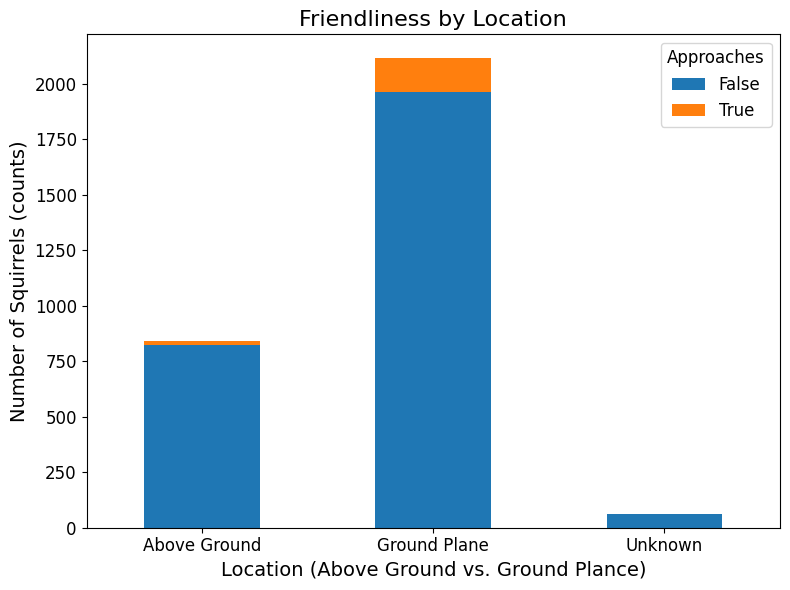

In [24]:
# if the location (above ground vs. ground plane) influences squirrel behavior 
shift_approach = df.groupby('Location')['Approaches'].value_counts().unstack()

# stacked bar plot
shift_approach.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.title('Friendliness by Location', fontsize=16)  
plt.xlabel('Location (Above Ground vs. Ground Plance)', fontsize=14)  
plt.ylabel('Number of Squirrels (counts)', fontsize=14)
plt.xticks([0, 1, 2], ['Above Ground', 'Ground Plane', 'Unknown'], rotation = 0, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Approaches", fontsize=12, title_fontsize=12)
plt.tight_layout()

# save_path = os.path.join(os.path.expanduser("~"), "Desktop", "Comparison_location.png")
# plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')
plt.show()

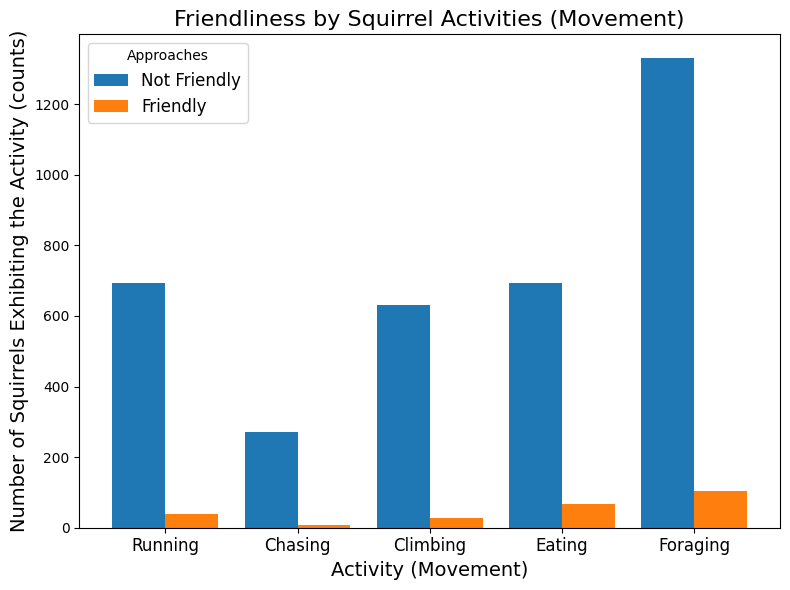

In [25]:
# Activities as a signal

# Group 1: Running, Chasing, Climbing, Eating, Foraging
activity_group_1 = ['Running', 'Chasing', 'Climbing', 'Eating', 'Foraging']
activity_approach_counts_1 = df.groupby('Approaches')[activity_group_1].sum().T

# Plot the results in a bar plot for group 1
plt.figure(figsize=(8, 6))
activity_approach_counts_1.plot(kind='bar', ax=plt.gca(), width=0.8)  # Remove stacked=True
plt.title('Friendliness by Squirrel Activities (Movement)', fontsize=16)
plt.xlabel('Activity (Movement)', fontsize=14)
plt.ylabel('Number of Squirrels Exhibiting the Activity (counts)', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.legend(['Not Friendly', 'Friendly'], title="Approaches", fontsize=12)
plt.tight_layout()

# save_path = os.path.join(os.path.expanduser("~"), "Desktop", "Comparison_movement_activities.png")
# plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')
plt.show()

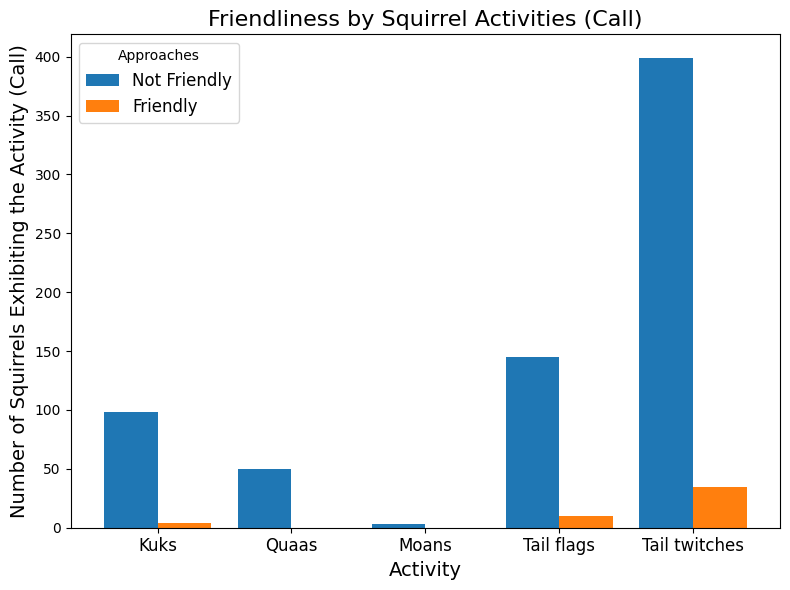

In [26]:
# Group 2: Kuks, Quaas, Moans, Tail flags, Tail twitches
activity_group_2 = ['Kuks', 'Quaas', 'Moans', 'Tail flags', 'Tail twitches']
activity_approach_counts_2 = df.groupby('Approaches')[activity_group_2].sum().T

# Plot the results in a stacked bar plot for group 2
plt.figure(figsize=(8, 6))
activity_approach_counts_2.plot(kind='bar', ax=plt.gca(), width = 0.8)
plt.title('Friendliness by Squirrel Activities (Call)', fontsize=16)
plt.xlabel('Activity', fontsize=14)
plt.ylabel('Number of Squirrels Exhibiting the Activity (Call)', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.legend(['Not Friendly', 'Friendly'], title="Approaches", fontsize=12)
plt.tight_layout()

# save_path = os.path.join(os.path.expanduser("~"), "Desktop", "Comparison_call_activities.png")
# plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')
plt.show()

# Models #

In [27]:
y = df['Approaches'] # targeted variable
X = df.loc[:, df.columns != 'Approaches'] # feature matrix

In [28]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ParameterGrid

from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost

from sklearn.metrics import precision_score   # here I chose precision as evaluation metrics to minimize False Positive
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#### Baseline Precision ####

In [29]:
# always predict the positive class
pos_count = sum(y == 1)
neg_count = sum(y == 0)

total_count = len(y)

baseline_precision = pos_count / total_count

print('Baseline Precision', baseline_precision)

Baseline Precision 0.058881905391994706


#### Store Preprocessing Encoders in Preprocessor ####

In [30]:
print(df.dtypes)

Shift                  object
Age                    object
Primary Fur Color      object
Highlight Fur Color    object
Location               object
Running                  bool
Chasing                  bool
Climbing                 bool
Eating                   bool
Foraging                 bool
Kuks                     bool
Quaas                    bool
Moans                    bool
Tail flags               bool
Tail twitches            bool
Approaches               bool
Indifferent              bool
Runs from                bool
dtype: object


In [31]:
# Define different-types features
categorical_ftrs = ['Shift', 'Age', 'Primary Fur Color', 'Location', 'Highlight Fur Color']
boolean_ftrs = ['Running', 'Chasing', 'Climbing', 'Eating', 'Foraging', 
                'Kuks', 'Quaas', 'Moans', 'Tail flags', 'Tail twitches', 
                'Indifferent', 'Runs from']

# Apply preprocessing and Combine all transformers
preprocessor = ColumnTransformer(
    transformers = [
        ('onehot', OneHotEncoder(sparse_output = False, handle_unknown = 'ignore'), categorical_ftrs),
        ('boolean', StandardScaler(), boolean_ftrs)])

## Logistic Regression ##

In [32]:
param_grid = {
    'logisticregression__C': [0.01, 0.1, 1, 10, 100],
    'logisticregression__penalty': ['elasticnet'],
    'logisticregression__l1_ratio': [0, 0.25, 0.5, 0.75, 1]}  # so that 0 indicates L2, 1 indicated L1

nr_states = 5
lr_test_scores = []
lr_final_models = []

# Hyperparameter tuning with folds
for i in range(nr_states):
    # First split to separate out the test set
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42*i)
    # splitter for other
    kf = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 42*i) # Imbalanced, stratify

    # logistic regression
    lr = LogisticRegression(solver = 'saga', max_iter = 220000, random_state = 42*i, class_weight = 'balanced')

    pipe = make_pipeline(preprocessor, lr)

    # GridSearchCV
    grid = GridSearchCV(pipe, param_grid = param_grid, scoring = 'precision', cv = kf, return_train_score = True, n_jobs = -1)

    # Fit the model on other and loops through the 4 different validation sets
    grid.fit(X_other, y_other)

    # Compare number of features before and after preprocessed
    if i == 0:  # Only print once
        best_pipe = grid.best_estimator_
        X_other_prep = best_pipe.named_steps['columntransformer'].transform(X_other)

        # Save preprocessed data
        # preprocessed_df = pd.DataFrame(
        #     X_other_prep, 
        #     columns = best_pipe.named_steps['columntransformer'].get_feature_names_out())
        # preprocessed_df['target'] = y_other.reset_index(drop = True)
        # desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")
        # csv_path = os.path.join(desktop_path, "preprocessed_data.csv")
        # preprocessed_df.to_csv(csv_path, index = False)
        
        print(f'Number of features before preprocessed: {X_other.shape[1]}')
        print(f'Number of features after preprocessing: {X_other_prep.shape[1]}')

    # Save results into a data frame
    results_lr = pd.DataFrame(grid.cv_results_)
    # print(results_lr)

    print('\nBest model parameters:', grid.best_params_)
    print('validation score:', grid.best_score_)
    # save the model 
    lr_final_models.append(grid)

    # calculate and save the test score
    y_test_pred = lr_final_models[-1].predict(X_test)
    test_score = precision_score(y_test, y_test_pred)
    lr_test_scores.append(test_score)
    print('test score:', test_score)

Number of features before preprocessed: 17
Number of features after preprocessing: 35

Best model parameters: {'logisticregression__C': 1, 'logisticregression__l1_ratio': 0.5, 'logisticregression__penalty': 'elasticnet'}
validation score: 0.18422219883686047
test score: 0.15789473684210525

Best model parameters: {'logisticregression__C': 1, 'logisticregression__l1_ratio': 0.5, 'logisticregression__penalty': 'elasticnet'}
validation score: 0.1667015543791634
test score: 0.2198581560283688

Best model parameters: {'logisticregression__C': 1, 'logisticregression__l1_ratio': 0.75, 'logisticregression__penalty': 'elasticnet'}
validation score: 0.18201681632532696
test score: 0.20279720279720279

Best model parameters: {'logisticregression__C': 1, 'logisticregression__l1_ratio': 0, 'logisticregression__penalty': 'elasticnet'}
validation score: 0.17783973637301811
test score: 0.15706806282722513

Best model parameters: {'logisticregression__C': 0.1, 'logisticregression__l1_ratio': 1, 'logist

In [33]:
print(f'Test Precision Mean: {np.mean(lr_test_scores)}')
print(f'Test Precision std: {np.std(lr_test_scores)}')

Test Precision Mean: 0.18196071779169562
Test Precision std: 0.02515848518842381


In [34]:
# Comparison with baseline precision
lr_above_baseline = (np.mean(lr_test_scores) - baseline_precision) / np.std(lr_test_scores)
print(f"{round(lr_above_baseline, 4)} standard deviations above the baseline")

4.8921 standard deviations above the baseline


<Figure size 600x600 with 0 Axes>

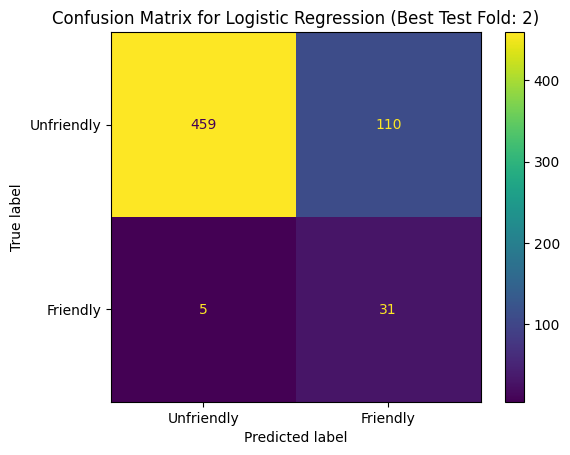

In [35]:
# Draw confusion matrix to check if our model did not always predict majority class
best_fold_index = max(range(len(lr_test_scores)), key=lambda i: lr_test_scores[i])
best_model = lr_final_models[best_fold_index].best_estimator_

X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42 * best_fold_index)

y_test_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_test_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Unfriendly", "Friendly"])
plt.figure(figsize=(6, 6))
disp.plot(values_format='d')
plt.title(f"Confusion Matrix for Logistic Regression (Best Test Fold: {best_fold_index + 1})")

# save_path = os.path.join(os.path.expanduser("~"), "Desktop", "Confusion_Matrix_LR.png")
# plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')
plt.show()

## Random Forest ##

In [53]:
param_grid = {
    'randomforestclassifier__max_depth': [1, 3, 10, 30, 100],
    'randomforestclassifier__max_features': [0.01, 0.1, 1, 10, 100]} 
nr_states = 5
rf_test_scores = []
rf_final_models = []
rf_test_sets = []  

for i in range(nr_states):
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42*i)
    kf = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 42*i)
    rf_test_sets.append((X_test, y_test))  # Save the test set for later use

    rf = RandomForestClassifier(random_state = 42*i, class_weight = 'balanced')

    pipe = make_pipeline(preprocessor, rf)

    grid = GridSearchCV(pipe, param_grid = param_grid, scoring = 'precision', cv = kf, return_train_score = True, n_jobs = -1)

    grid.fit(X_other, y_other)

    results_rf = pd.DataFrame(grid.cv_results_)
    # print(results_rf)

    print('\nBest model parameters:', grid.best_params_)
    print('validation score:', grid.best_score_)

    rf_final_models.append(grid)

    y_test_pred = rf_final_models[-1].predict(X_test)
    test_score = precision_score(y_test, y_test_pred)
    rf_test_scores.append(test_score)
    print('test score:', test_score)


Best model parameters: {'randomforestclassifier__max_depth': 30, 'randomforestclassifier__max_features': 10}
validation score: 0.24607182266146665
test score: 0.17543859649122806

Best model parameters: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 0.1}
validation score: 0.22902524917611128
test score: 0.29508196721311475

Best model parameters: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 10}
validation score: 0.23478402360258901
test score: 0.2535211267605634

Best model parameters: {'randomforestclassifier__max_depth': 30, 'randomforestclassifier__max_features': 10}
validation score: 0.30050099206349207
test score: 0.15873015873015872

Best model parameters: {'randomforestclassifier__max_depth': 30, 'randomforestclassifier__max_features': 10}
validation score: 0.28007700938392494
test score: 0.19148936170212766


In [54]:
print(f'Test Precision Mean: {np.mean(rf_test_scores)}')
print(f'Test Precision std: {np.std(rf_test_scores)}')

Test Precision Mean: 0.2148522421794385
Test Precision std: 0.051344014870378964


In [55]:
# Comparison with baseline precision
rf_above_baseline = (np.mean(rf_test_scores) - baseline_precision) / np.std(rf_test_scores)
print(f"{round(rf_above_baseline, 4)} standard deviations above the baseline")

3.0378 standard deviations above the baseline


<Figure size 600x600 with 0 Axes>

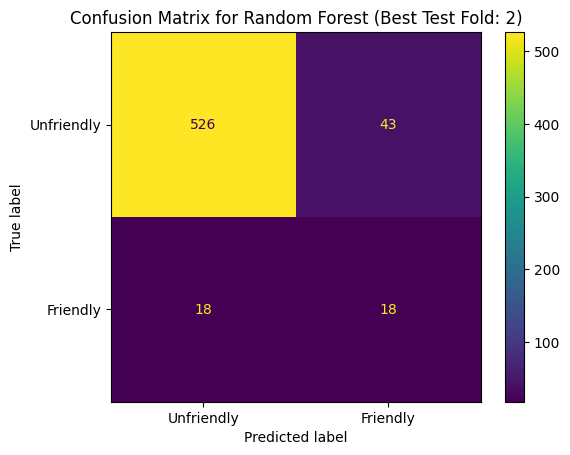

In [56]:
# Draw confusion matrix to check if our model did not always predict majority class
best_fold_index = max(range(len(rf_test_scores)), key=lambda i: rf_test_scores[i])
best_model = rf_final_models[best_fold_index].best_estimator_

X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42 * best_fold_index)

y_test_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_test_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Unfriendly", "Friendly"])
plt.figure(figsize=(6, 6))
disp.plot(values_format='d')
plt.title(f"Confusion Matrix for Random Forest (Best Test Fold: {best_fold_index + 1})")
# save_path = os.path.join(os.path.expanduser("~"), "Desktop", "Confusion_Matrix_RF.png")
# plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')
plt.show()

## SVC ##

In [36]:
param_grid = {
    'svc__gamma': [0.01, 0.1, 1, 10, 100],
    'svc__C': [0.01, 0.1, 1, 10, 100]}
nr_states = 5
svc_test_scores = []
svc_final_models = []

for i in range(nr_states):
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42*i)
    kf = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 42*i)

    svc = SVC(probability = True, random_state = 42*i, class_weight = 'balanced')

    pipe = make_pipeline(preprocessor, svc)

    grid = GridSearchCV(pipe, param_grid = param_grid, scoring = 'precision', cv = kf, return_train_score = True, n_jobs = -1)

    grid.fit(X_other, y_other)

    results_svc = pd.DataFrame(grid.cv_results_)
    # print(results_svc)

    print('\nBest model parameters:', grid.best_params_)
    print('validation score:', grid.best_score_)

    svc_final_models.append(grid)

    y_test_pred = svc_final_models[-1].predict(X_test)

    # Suppress the warning at the point of precision calculation
    test_score = precision_score(y_test, y_test_pred)
    svc_test_scores.append(test_score)
    print('test score:', test_score)


Best model parameters: {'svc__C': 0.1, 'svc__gamma': 10}
validation score: 0.20960764113337643
test score: 0.19607843137254902

Best model parameters: {'svc__C': 1, 'svc__gamma': 0.1}
validation score: 0.19361645299145303
test score: 0.22429906542056074

Best model parameters: {'svc__C': 0.1, 'svc__gamma': 10}
validation score: 0.20601472995090017
test score: 0.23809523809523808

Best model parameters: {'svc__C': 0.1, 'svc__gamma': 10}
validation score: 0.2877164502164502
test score: 0.16363636363636364

Best model parameters: {'svc__C': 0.1, 'svc__gamma': 10}
validation score: 0.26377551020408163
test score: 0.16666666666666666


In [37]:
print(f'Test Precision Mean: {np.mean(svc_test_scores)}')
print(f'Test Precision std: {np.std(svc_test_scores)}')

Test Precision Mean: 0.19775515303827562
Test Precision std: 0.029884105867954123


In [46]:
# Comparison with baseline precision
svc_above_baseline = (np.mean(svc_test_scores) - baseline_precision) / np.std(svc_test_scores)
print(f"{round(svc_above_baseline, 4)} standard deviations above the baseline")

4.6471 standard deviations above the baseline


<Figure size 600x600 with 0 Axes>

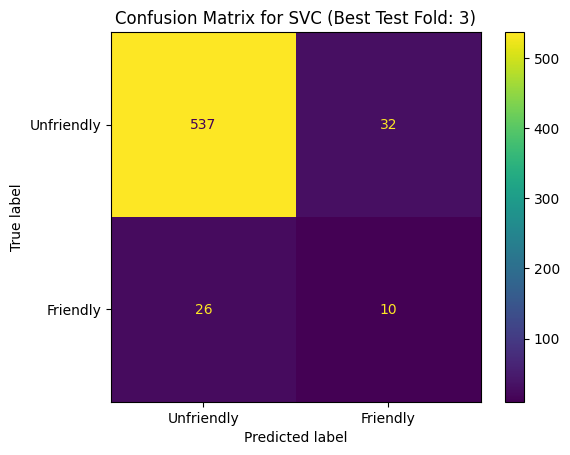

In [47]:
# Draw confusion matrix to check if our model did not always predict majority class
best_fold_index = max(range(len(svc_test_scores)), key=lambda i: svc_test_scores[i])
best_model = svc_final_models[best_fold_index].best_estimator_

X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42 * best_fold_index)

y_test_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_test_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Unfriendly", "Friendly"])
plt.figure(figsize=(6, 6))
disp.plot(values_format='d')
plt.title(f"Confusion Matrix for SVC (Best Test Fold: {best_fold_index + 1})")
# save_path = os.path.join(os.path.expanduser("~"), "Desktop", "Confusion_Matrix_SVC.png")
# plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')
plt.show()

## XGBoost ##

In [48]:
from sklearn.utils.class_weight import compute_sample_weight

param_grid = {
    'learning_rate': [0.03],
    'n_estimators': [10000],
    'seed': [0],
    'reg_alpha': [0e0, 1e-2, 1e-1, 1e1, 1e2],
    #"reg_lambda": [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
    #"missing": [np.nan], 
    'max_depth': [1, 3, 10, 30, 100],
    'colsample_bytree': [0.1],
    'subsample': [0.33]
}

nr_states = 5
xgb_test_scores = []
xgb_final_models = []


for i in range(nr_states):
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42 * i)

    preprocessor.fit(X_other)
    X_other_prep = preprocessor.transform(X_other)
    X_test_prep = preprocessor.transform(X_test)

    sample_weights = compute_sample_weight(class_weight='balanced', y=y_other)

    kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42 * i)

    best_model = None
    best_val_score = -np.inf
    best_params = None

    for train_idx, val_idx in kf.split(X_other_prep, y_other):
        X_train, X_val = X_other_prep[train_idx], X_other_prep[val_idx]
        y_train, y_val = y_other.iloc[train_idx], y_other.iloc[val_idx]

        train_sample_weights = sample_weights[train_idx]

        for params in ParameterGrid(param_grid):
            xgb = xgboost.XGBClassifier(eval_metric='logloss', random_state=42 * i, n_jobs=-1)
            xgb.set_params(**params, early_stopping_rounds=100)

            xgb.fit(
                X_train,
                y_train,
                sample_weight=train_sample_weights,
                eval_set=[(X_val, y_val)],
                verbose=False
            )

            y_val_pred = xgb.predict(X_val)
            val_score = precision_score(y_val, y_val_pred)

            if val_score > best_val_score:
                best_val_score = val_score
                best_model = xgb
                best_params = params

    y_test_pred = best_model.predict(X_test_prep)
    test_score = precision_score(y_test, y_test_pred)
    xgb_test_scores.append(test_score)
    xgb_final_models.append(best_model)

    print("\nBest Parameters:", best_params)
    print("Best Validation Precision:", best_val_score)
    print("Test Precision:", test_score)


Best Parameters: {'colsample_bytree': 0.1, 'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 10000, 'reg_alpha': 0.1, 'seed': 0, 'subsample': 0.33}
Best Validation Precision: 0.224
Test Precision: 0.18064516129032257

Best Parameters: {'colsample_bytree': 0.1, 'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 10000, 'reg_alpha': 0.01, 'seed': 0, 'subsample': 0.33}
Best Validation Precision: 0.19083969465648856
Test Precision: 0.234375

Best Parameters: {'colsample_bytree': 0.1, 'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 10000, 'reg_alpha': 0.1, 'seed': 0, 'subsample': 0.33}
Best Validation Precision: 0.1968503937007874
Test Precision: 0.2222222222222222

Best Parameters: {'colsample_bytree': 0.1, 'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 10000, 'reg_alpha': 0.1, 'seed': 0, 'subsample': 0.33}
Best Validation Precision: 0.20437956204379562
Test Precision: 0.17647058823529413

Best Parameters: {'colsample_bytree': 0.1, 'learning_rate': 0.03, 'max_depth'

In [49]:
print(f'Test Precision Mean: {np.mean(xgb_test_scores)}')
print(f'Test Precision std: {np.std(xgb_test_scores)}')

Test Precision Mean: 0.20889644050341394
Test Precision std: 0.0251186109446394


In [50]:
# Comparison with baseline precision
xgb_above_baseline = (np.mean(xgb_test_scores) - baseline_precision) / np.std(xgb_test_scores)
print(f"{round(xgb_above_baseline, 4)} standard deviations above the baseline")

5.9722 standard deviations above the baseline


<Figure size 600x600 with 0 Axes>

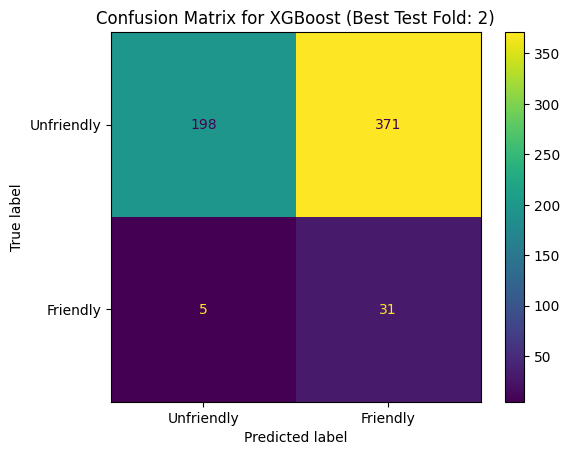

In [51]:
# Draw confusion matrix to check if our model did not always predict majority class
best_fold_index = max(range(len(xgb_test_scores)), key=lambda i: xgb_test_scores[i])

best_model = xgb_final_models[best_fold_index]

X_other, X_test, y_other, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42 * best_fold_index
)

X_test_prep = preprocessor.transform(X_test)

y_test_pred = best_model.predict(X_test_prep)

cm = confusion_matrix(y_test, y_test_pred, labels=[0, 1])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Unfriendly", "Friendly"])
plt.figure(figsize=(6, 6))
disp.plot(values_format='d')
plt.title(f"Confusion Matrix for XGBoost (Best Test Fold: {best_fold_index + 1})")
# save_path = os.path.join(os.path.expanduser("~"), "Desktop", "Confusion_Matrix_XGB.png")
# plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')
plt.show()

# Model Test Score Difference #

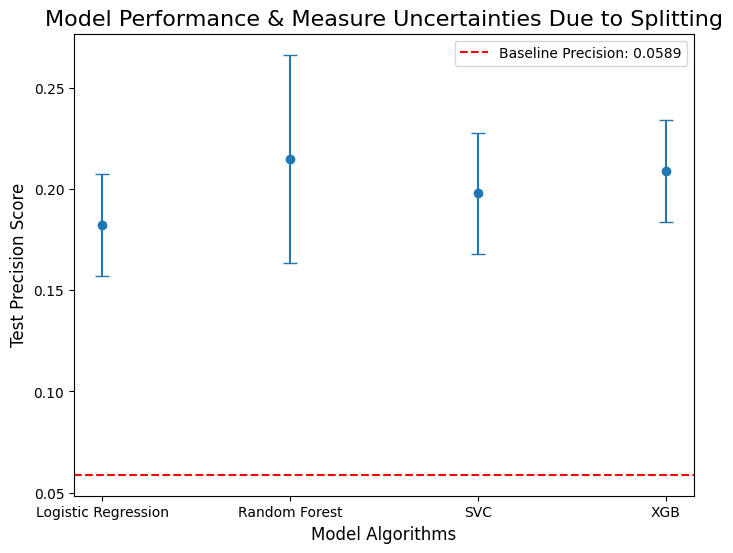

In [58]:
# Comparison based on precision
acc_means = [np.mean(lr_test_scores), np.mean(rf_test_scores), np.mean(svc_test_scores), np.mean(xgb_test_scores)]
acc_stds = [np.std(lr_test_scores), np.std(rf_test_scores), np.std(svc_test_scores), np.std(xgb_test_scores)]
plt.figure(figsize = (8, 6))
plt.errorbar(['Logistic Regression', 'Random Forest', 'SVC', 'XGB'], acc_means, yerr = acc_stds, capsize = 5, fmt = 'o')
plt.title('Model Performance & Measure Uncertainties Due to Splitting', fontsize=16)
plt.xlabel('Model Algorithms', fontsize=12)
plt.ylabel('Test Precision Score', fontsize=12)
plt.axhline(y=baseline_precision, color='r', linestyle='--', label=f'Baseline Precision: {baseline_precision:.4f}')
plt.legend()
# save_path = os.path.join(os.path.expanduser("~"), "Desktop", "Comparison_Models_Performance.png")
# plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')
plt.show()

#### Based on the plot, Random Forest is the best model ####

In [49]:
# Store the best Random Forest Model
import pickle

best_index = rf_test_scores.index(max(rf_test_scores))
best_model = rf_final_models[best_index].best_estimator_  

# desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")
# model_path = os.path.join(desktop_path, "best_rf_model.pkl")
# with open(model_path, 'wb') as model_file:
#     pickle.dump(best_model, model_file)
# print(f"Best Random Forest model saved to {model_path}")

In [50]:
# Store prediction using best model
X_test, y_test = rf_test_sets[best_index]
X_test_prep = best_model.named_steps['columntransformer'].transform(X_test)

y_pred = best_model.named_steps['randomforestclassifier'].predict(X_test_prep)

prediction_df = pd.DataFrame({'predictions': y_pred})
# desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")
# prediction_path = os.path.join(desktop_path, "rf_predictions.csv")
# prediction_df.to_csv(prediction_path, index=False)
# print(f"Predictions saved to {prediction_path}")

In [51]:
df_test = best_model[0].transform(rf_test_sets[best_index][0])
df_test = pd.DataFrame(data = df_test, columns = best_model[0].get_feature_names_out())
df_test.head()

,onehot__Shift_AM,onehot__Shift_PM,onehot__Age_Adult,onehot__Age_Juvenile,onehot__Age_Unknown,onehot__Primary Fur Color_Black,onehot__Primary Fur Color_Cinnamon,onehot__Primary Fur Color_Gray,onehot__Primary Fur Color_Unknown,onehot__Location_Above Ground,...,boolean__Climbing,boolean__Eating,boolean__Foraging,boolean__Kuks,boolean__Quaas,boolean__Moans,boolean__Tail flags,boolean__Tail twitches,boolean__Indifferent,boolean__Runs from
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.531111,-0.575758,-0.955497,-0.184979,-0.129695,-0.035245,-0.228515,-0.401031,-0.951545,1.878321
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,-0.531111,1.736839,-0.955497,-0.184979,-0.129695,-0.035245,-0.228515,-0.401031,-0.951545,1.878321
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.531111,-0.575758,1.046576,-0.184979,-0.129695,-0.035245,-0.228515,-0.401031,1.050923,-0.532390
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,-0.531111,1.736839,-0.955497,-0.184979,-0.129695,-0.035245,-0.228515,-0.401031,1.050923,-0.532390
4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.531111,-0.575758,-0.955497,-0.184979,-0.129695,-0.035245,-0.228515,-0.401031,1.050923,-0.532390


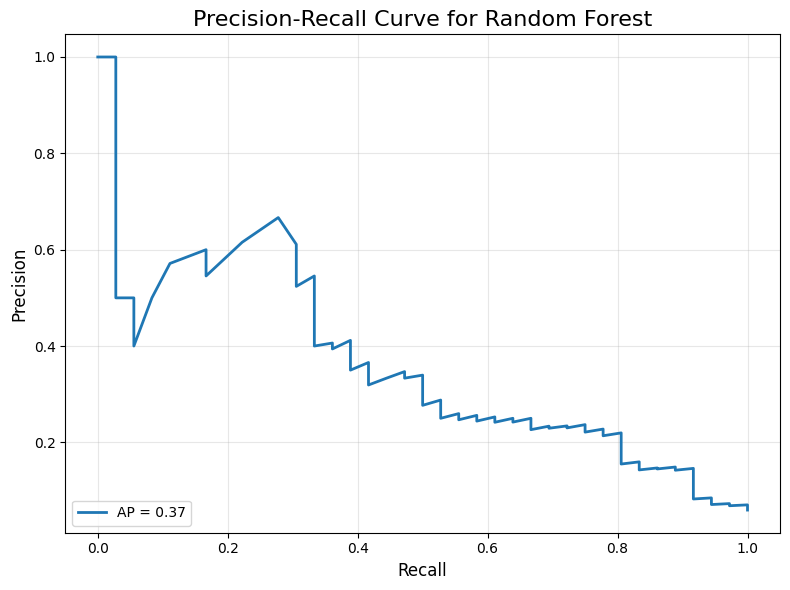

In [52]:
# Draw the precision-recall curve
from sklearn.metrics import precision_recall_curve, average_precision_score

y_proba = best_model.named_steps['randomforestclassifier'].predict_proba(X_test_prep)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
average_precision = average_precision_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, lw = 2, label=f'AP = {average_precision:.2f}')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve for Random Forest', fontsize=16)
plt.legend(loc='lower left')
plt.grid(alpha=0.3)
plt.tight_layout()
# save_path = os.path.join(os.path.expanduser("~"), "Desktop", "Precision_Recall_RF.png")
# plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')
plt.show()

## Global Feature Importance - Permutation Importance ##

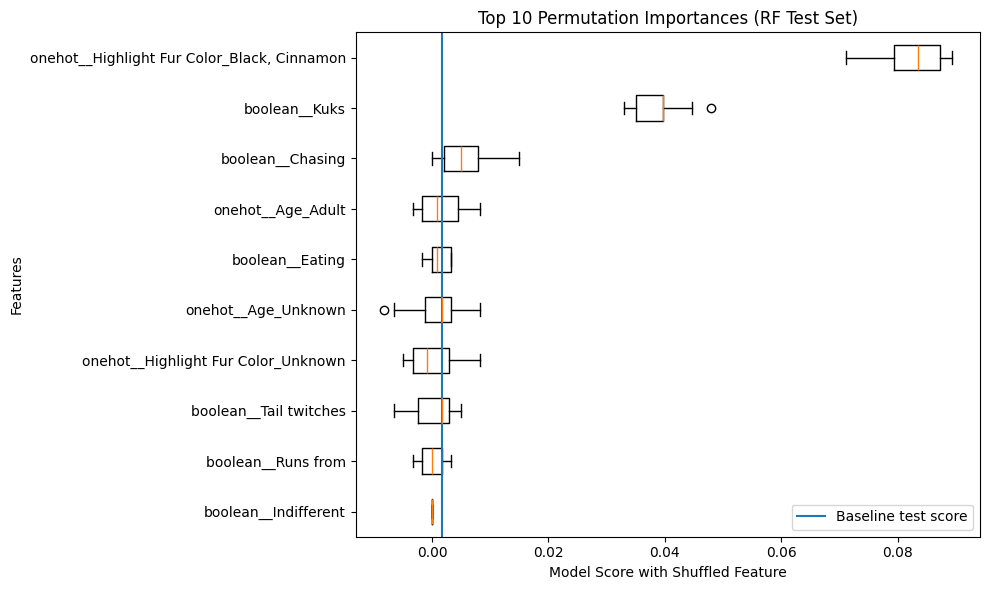

In [64]:
from sklearn.inspection import permutation_importance

feature_names = preprocessor.get_feature_names_out()
result = permutation_importance(best_model.named_steps['randomforestclassifier'], df_test, rf_test_sets[best_index][1], n_repeats = 10, random_state = 0)

importances = result.importances
sorted_indices = np.argsort(importances.mean(axis=1))[::-1][:10] 
reverse_indices = sorted_indices[::-1]

plt.figure(figsize=(10, 6))
plt.boxplot(importances[reverse_indices].T, vert=False, labels=np.array(feature_names)[sorted_indices[:10]])
plt.axvline(result.importances_mean.mean(), label='Baseline test score')
plt.title("Top 10 Permutation Importances (RF Test Set)")
plt.xlabel("Model Score with Shuffled Feature")
plt.ylabel("Features")
plt.legend()
plt.tight_layout()
# save_path = os.path.join(os.path.expanduser("~"), "Desktop", "Global_Permutation_Importances.png")
# plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')
plt.show()

## Global Feature Importance - Gini ##

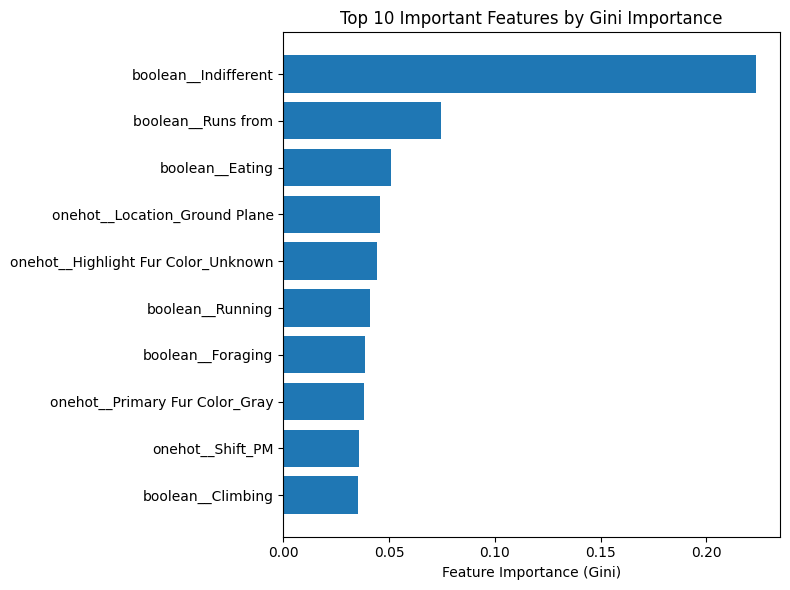

In [54]:
importances = best_model[-1].feature_importances_  
sorted_indices = np.argsort(importances) 

top_indices = sorted_indices[-10:]

plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 10})
plt.barh(np.arange(10), importances[top_indices]) 
plt.yticks(np.arange(10), np.array(df_test.columns)[top_indices])  
plt.xlabel('Feature Importance (Gini)')
plt.title('Top 10 Important Features by Gini Importance')
plt.tight_layout()
# save_path = os.path.join(os.path.expanduser("~"), "Desktop", "Global_Gini_Importances.png")
# plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')
plt.show()

## Global Feature Importance - Shap Value ##

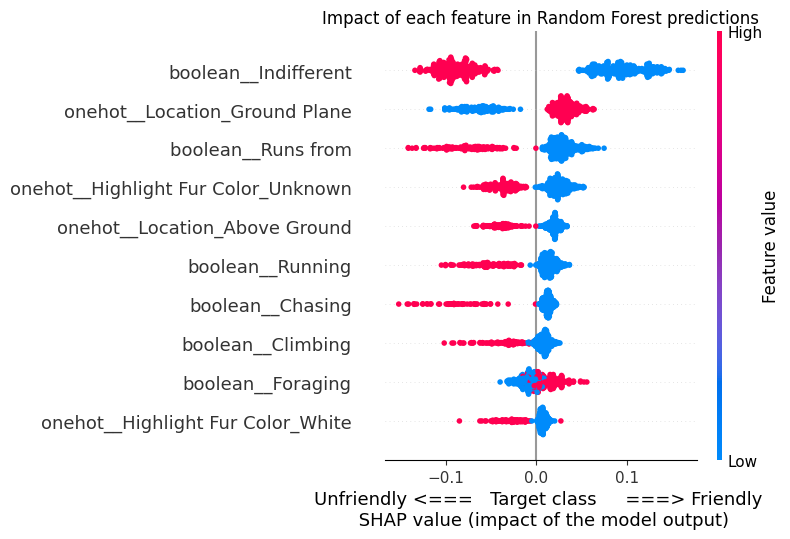

In [55]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(best_model.named_steps['randomforestclassifier'], df_test)

shap_values = explainer.shap_values(df_test)

shap.summary_plot(shap_values[:,:,1], df_test, feature_names = feature_names, max_display=10, show = False)  
fig = plt.gcf()
ax = plt.gca()
ax.set_xlabel("Unfriendly <===   Target class     ===> Friendly \n SHAP value (impact of the model output)")
ax.set_title("Impact of each feature in Random Forest predictions")
plt.tight_layout()
# save_path = os.path.join(os.path.expanduser("~"), "Desktop", "Global_SHAP.png")
# plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')
plt.show()

## Local Feature Importance: SHAP Values ##

In [56]:
print(explainer.expected_value[1])

0.24989406472049375


In [66]:
# Model strongly predict friendly class
shap.initjs()
index = 120
shap.force_plot(explainer.expected_value[1], 
                shap_values[index, :, 1], 
                features = df_test.iloc[index, :], 
                feature_names = feature_names)

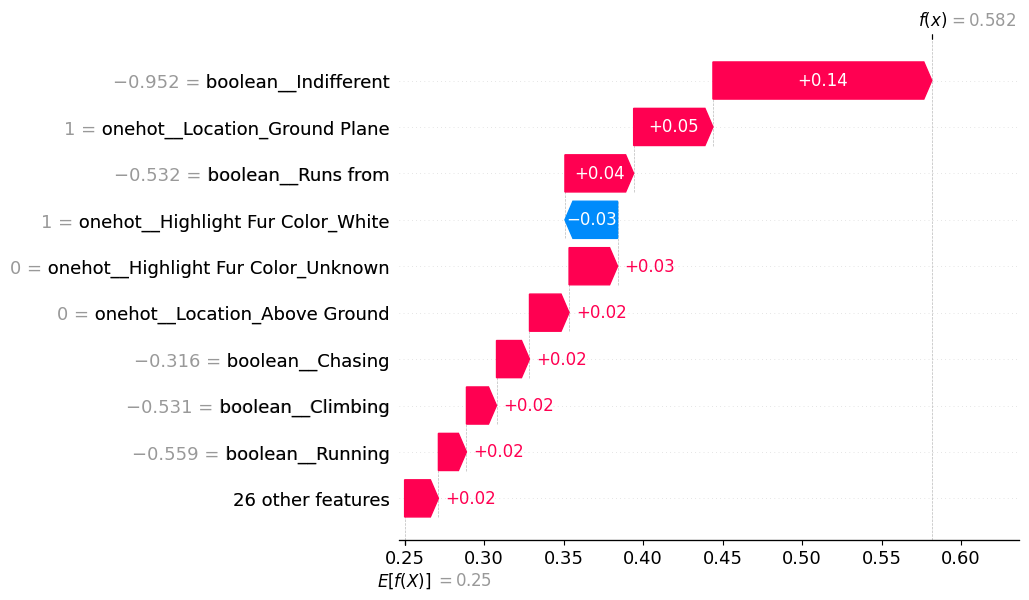

<Figure size 640x480 with 0 Axes>

In [72]:
# Equivalent Waterfall Plot 
shap_values_obs = shap_values[120, :, 1]

explanation = shap.Explanation(
    values = shap_values_obs,
    base_values = explainer.expected_value[1],
    data = df_test.iloc[120, :],
    feature_names = feature_names
)

shap.plots.waterfall(explanation) # show = False
plt.tight_layout()

# save_path = os.path.join(os.path.expanduser("~"), "Desktop", "SHAP_waterfall_120.png")
# plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')

In [73]:
# Model predicts unfriendly class with high confidence
shap.initjs()
index = 478
shap.force_plot(explainer.expected_value[1], 
                shap_values[index, :, 1], 
                features = df_test.iloc[index, :], 
                feature_names = feature_names)

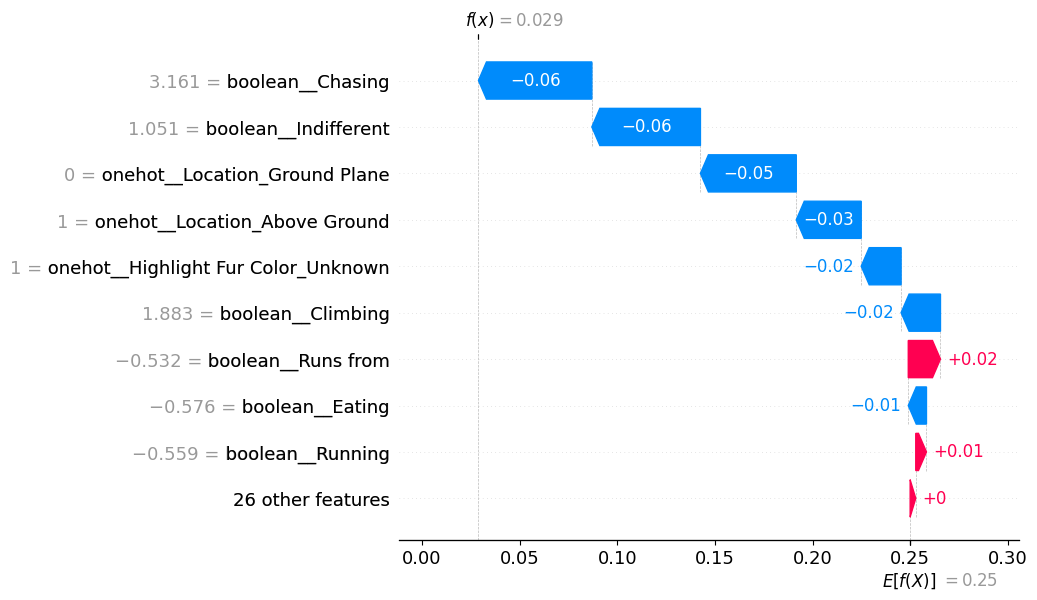

<Figure size 640x480 with 0 Axes>

In [74]:
# Equivalent Waterfall Plot 
shap_values_obs = shap_values[478, :, 1]

explanation = shap.Explanation(
    values = shap_values_obs,
    base_values = explainer.expected_value[1],
    data = df_test.iloc[478, :],
    feature_names = feature_names
)

shap.plots.waterfall(explanation) # show = False
plt.tight_layout()

# save_path = os.path.join(os.path.expanduser("~"), "Desktop", "SHAP_waterfall_478.png")
# plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')